## Import Packages

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from matplotlib.patches import Polygon
%matplotlib inline

### get the distortion coefficients and the camera matrix and save to pickle file
```
images = glob.glob('camera_cal/calibration*.jpg')
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane
nx = 9
ny = 5
# Prepare object points, like (0,0,0), (1,0,0), (2,0,0),...,(8,4,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,5), None)
    # If corners are found, add object points, image points
    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dist_pickle = {'mtx':mtx, 'dist':dist}
pickle.dump(dist_pickle, open( "dist_pickle.p", "wb" ) )
```

In [2]:
dist_pickle = pickle.load( open( "dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

## Helper Functions

In [3]:
def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def cal_undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

def gradient_threshold(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 15#20
    thresh_max = 150#100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 150#170
    s_thresh_max = 255#255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

# Four source coordinates
src = np.float32(
[[684, 450],#top right
[1100, 720],#bottom right
[200, 720],#bottom left
[596, 450]])#top left

# Four desired coordinate
dst = np.float32(
[[950, 0],#top right
[950, 720],#bottom right
[410, 720],#bottom left
[410, 0]])#top left

def warp(img, src, dst):
    """
    perform the perspective transform and return the warped image
    """
    #Define calibration box in source(original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    # Compute the perspective transform, M
    M = cv2.getPerspectiveTransform(src, dst)
    # Reverse perspective transform
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Create warped image - use linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, Minv

def initial_fit_poly(binary_warped, nwindows=9):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit, right_fit
    
def fit_poly(binary_warped, left_fit, right_fit):    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Calculate the vehicle position
    position_to_left = (680-(right_fitx[719]+left_fitx[719])/2) *3.7/700
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    left_curverad, right_curverad = curvature(leftx, lefty, rightx, righty, left_fitx, right_fitx, ploty)    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return left_fitx,right_fitx, ploty, left_curverad, right_curverad, result, position_to_left

def curvature(leftx, lefty, rightx, righty, left_fit, right_fit, ploty): 
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    # print(left_curverad, right_curverad)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

def draw_lines(undistorted,Minv,binary_warped,left_fitx,right_fitx, ploty, image_shape, left_curverad, right_curverad, position_to_left):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_shape[1], image_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    cv2.putText(result,'Radias of Curvature = {:.0f} m'.format(max([left_curverad, right_curverad])),(50, 70), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,'Vehicle is {:.2f} m left of center'.format(position_to_left),(50, 140), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),2,cv2.LINE_AA)
    
    return result


### Calibrate camera

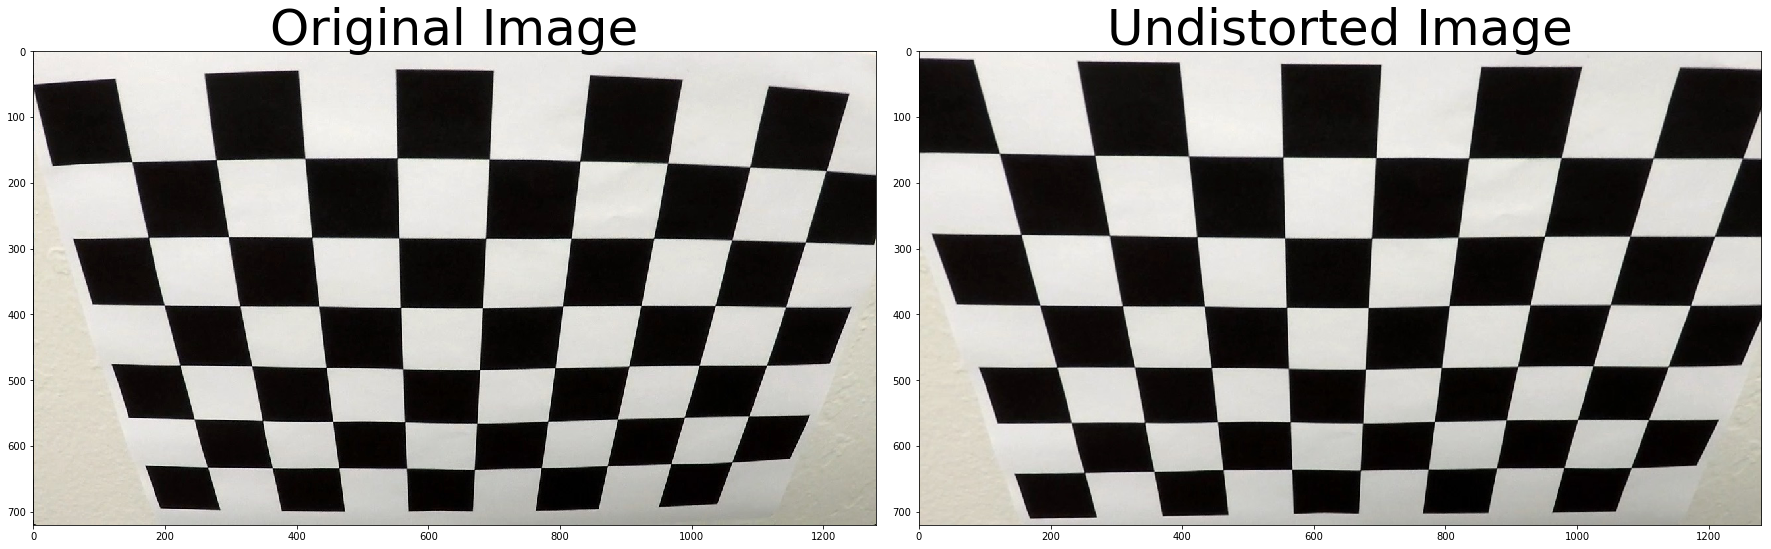

In [4]:
fname = 'camera_cal/calibration2.jpg'
img = mpimg.imread(fname)
undistorted = cal_undistort(img, mtx, dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/undistort.png')

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

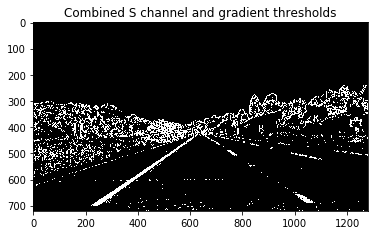

In [5]:
fname = 'test_images/straight_lines1.jpg'
image = mpimg.imread(fname)
undistorted = cal_undistort(image, mtx, dist)  
thresholded = gradient_threshold(undistorted)    

# Plotting thresholded images
plt.imshow(thresholded, cmap='gray')
plt.title('Combined S channel and gradient thresholds')
plt.savefig('output_images/thresholding.png')

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


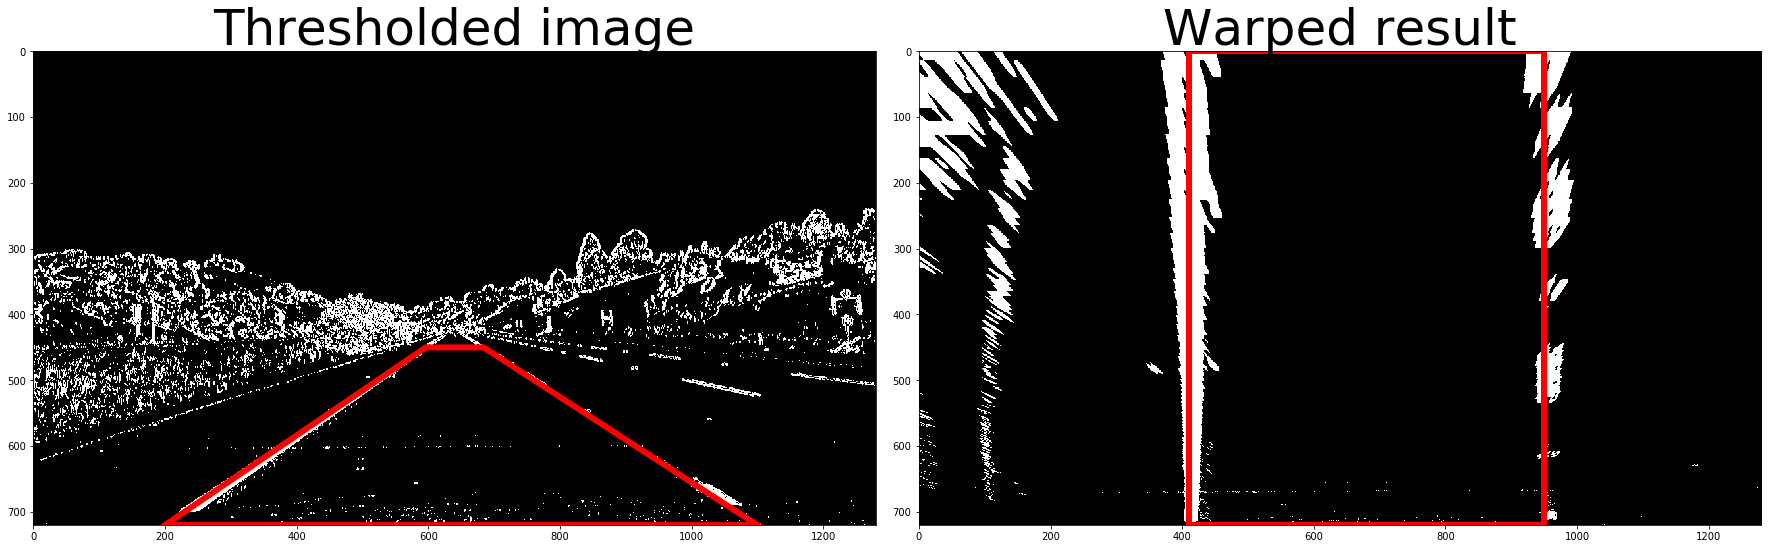

In [6]:
binary_warped, Minv = warp(thresholded,src,dst)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.add_patch(Polygon(src, fill=False, color='red', linewidth=6.0))
ax1.imshow(thresholded, cmap='gray')
ax1.set_title('Thresholded image', fontsize=50)
ax2.add_patch(Polygon(dst, fill=False, color='red', linewidth=6.0))
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Warped result', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('output_images/warping.png')

In [7]:
# Initialize the polynomial fit of lane lines using sliding window
initial_left_fit, initial_right_fit = initial_fit_poly(binary_warped)
# Update the fit
left_fitx,right_fitx, ploty, left_curverad, right_curverad, result, position_to_left = fit_poly(binary_warped, initial_left_fit, initial_right_fit)

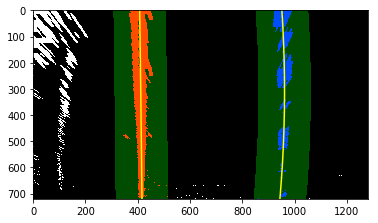

In [8]:
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.savefig('output_images/fit_poly.png')

In [9]:
left_fitx[719], right_fitx[719], ploty[719]
(680-(right_fitx[719]+left_fitx[719])/2) *3.7/700

-0.0002811517193652305

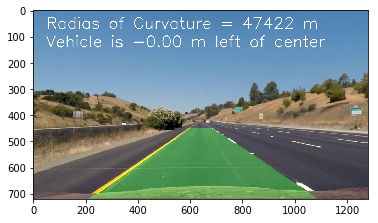

In [10]:
result = draw_lines(undistorted,Minv,binary_warped,left_fitx,right_fitx, ploty, image.shape, left_curverad, right_curverad, position_to_left)
plt.imshow(result)


### Test on images
test_images: 'straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg'

In [11]:
def process_image(image):
    undistorted = cal_undistort(image, mtx, dist)  
    thresholded = gradient_threshold(undistorted)    
    binary_warped, Minv = warp(thresholded,src,dst)
    left_fitx,right_fitx, ploty, left_curverad, right_curverad, result, position_to_left = fit_poly(binary_warped, initial_left_fit, initial_right_fit)
    result = draw_lines(undistorted,Minv,binary_warped,left_fitx,right_fitx, ploty, image.shape, left_curverad, right_curverad, position_to_left)
    return result

In [12]:
cv2.imwrite('output_images/1.png', cv2.cvtColor(process_image(mpimg.imread('test_images/straight_lines1.jpg')), cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/2.png', cv2.cvtColor(process_image(mpimg.imread('test_images/straight_lines2.jpg')), cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/3.png', cv2.cvtColor(process_image(mpimg.imread('test_images/test1.jpg')), cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/4.png', cv2.cvtColor(process_image(mpimg.imread('test_images/test2.jpg')), cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/5.png', cv2.cvtColor(process_image(mpimg.imread('test_images/test3.jpg')), cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/6.png', cv2.cvtColor(process_image(mpimg.imread('test_images/test4.jpg')), cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/7.png', cv2.cvtColor(process_image(mpimg.imread('test_images/test5.jpg')), cv2.COLOR_RGB2BGR))
cv2.imwrite('output_images/8.png', cv2.cvtColor(process_image(mpimg.imread('test_images/test6.jpg')), cv2.COLOR_RGB2BGR))

True

## Test on Videos

We can test our solution on the provided videos:

`project_video.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [13]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [14]:
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
white_output = 'test.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████▉| 1260/1261 [02:10<00:00,  7.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

CPU times: user 2min 55s, sys: 27.1 s, total: 3min 22s
Wall time: 2min 11s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))